In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

#import tensorflow as tf
#tf.random.set_seed(2027)  # set random seed

#import dask
#import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import get_logger, get_colormap, emtf_nbtools

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
#logger.info('Using tensorflow : {}'.format(tf.__version__))
#logger.info('Using keras      : {}'.format(tf.keras.__version__))
#logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using dask       : {}'.format(dask.__version__))

[INFO    ] Using cmssw      : CMSSW_11_1_7
[INFO    ] Using python     : 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.4.2


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

maxevents = 200_000
#maxevents = -1

# Input files
effie_fname = 'effie.211018.npz'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 0
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : 200000


### Load data

In [4]:
def load_effie():
  logger.info('Loading from {}'.format(effie_fname))
  effie = {}
  with np.load(effie_fname) as loaded:
    effie.update(loaded)
  logger.info('effie: {}'.format({k: (v.shape, v.dtype.name) for (k, v) in effie.items()}))
  return effie

In [5]:
# Load data
effie_data = load_effie()

[INFO    ] Loading from effie.211018.npz
[INFO    ] effie: {'eff_vs_geneta_highpt_l1pt20': ((96524,), 'float32'), 'eff_vs_geneta_lowpt_all': ((31096,), 'float32'), 'eff_vs_geneta_lowpt_l1pt5': ((19437,), 'float32'), 'eff_vs_genpt_l1pt10': ((106778,), 'float32'), 'eff_vs_genpt_all': ((120468,), 'float32'), 'eff_vs_genpt_l1pt20': ((96911,), 'float32'), 'eff_vs_genpt_l1pt5': ((112449,), 'float32'), 'eff_vs_genpt_l1pt30': ((88319,), 'float32'), 'eff_vs_genpt_l1pt50': ((70413,), 'float32'), 'eff_vs_geneta_highpt_all': ((162961,), 'float32'), 'eff_vs_genpt_l1pt40': ((79994,), 'float32')}


### Plot results

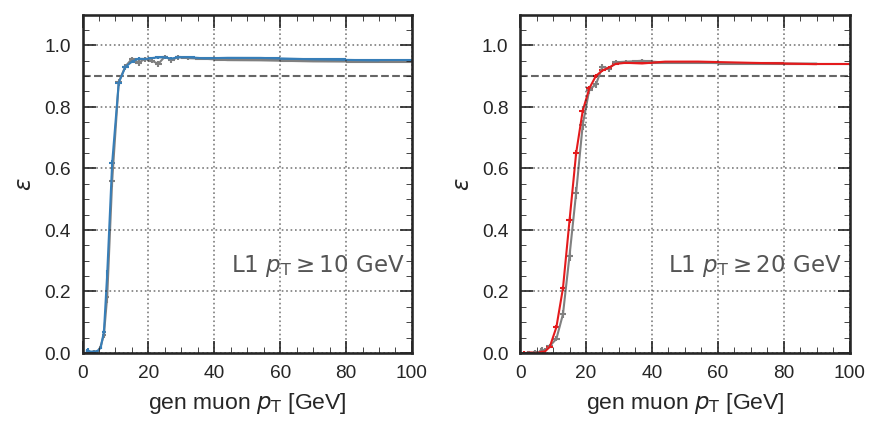

In [6]:
# Efficiency vs pt (comparison with p2tdr)
eff_pt_bins_p2tdr = np.array([0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20.,
  22., 24., 26., 28., 30., 34., 40., 48., 60., 80., 100.], dtype=np.float32)
num_hist_p2tdr_pt5 = np.array([   0,    0,    0,    0,    6,   24,  140,  351,  379,  359,  799,  825,
  783,  789,  762,  775,  809,  780,  790,  754,  802, 1566, 2322, 3100, 4690, 7794, 7830], dtype=np.int32)
denom_hist_p2tdr_pt5 = np.array([   0,    0,    0,    0,  416,  411,  390,  438,  420,  387,  834,  853,
  811,  818,  798,  806,  846,  826,  816,  789,  830, 1629, 2419, 3239, 4910, 8182, 8226], dtype=np.int32)
num_hist_p2tdr_pt10 = np.array([   0,    0,    0,    0,    1,    2,    1,    9,   25,   71,  466,  751,
  755,  782,  753,  770,  804,  776,  786,  751,  798, 1561, 2313, 3083, 4670, 7754, 7786], dtype=np.int32)
denom_hist_p2tdr_pt10 = np.array([   0,    0,    0,    0,  416,  411,  390,  438,  420,  387,  834,  853,
  811,  818,  798,  806,  846,  826,  816,  789,  830, 1629, 2419, 3239, 4910, 8182, 8226], dtype=np.int32)
num_hist_p2tdr_pt20 = np.array([   0,    0,    0,    0,    1,    0,    1,    0,    5,    3,   19,   39,
  102,  259,  415,  598,  724,  721,  759,  729,  784, 1542, 2297, 3056, 4632, 7692, 7736], dtype=np.int32)
denom_hist_p2tdr_pt20 = np.array([   0,    0,    0,    0,  416,  411,  390,  438,  420,  387,  834,  853,
  811,  818,  798,  806,  846,  826,  816,  789,  830, 1629, 2419, 3239, 4910, 8182, 8226], dtype=np.int32)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

for i in range(2):
  if i == 0:
    # 10 GeV
    color = '#377eb8'
    denom_data = effie_data['eff_vs_genpt_all']
    num_data = effie_data['eff_vs_genpt_l1pt10']
    color_ref = 'gray'
    denom_hist_ref = denom_hist_p2tdr_pt10
    num_hist_ref = num_hist_p2tdr_pt10
    text = r'$\mathrm{L1}\ p_{\mathrm{T}} \geq 10~\mathrm{GeV}$'
  else:
    # 20 GeV
    color = '#e41a1c'
    denom_data = effie_data['eff_vs_genpt_all']
    num_data = effie_data['eff_vs_genpt_l1pt20']
    color_ref = 'gray'
    denom_hist_ref = denom_hist_p2tdr_pt20
    num_hist_ref = num_hist_p2tdr_pt20
    text = r'$\mathrm{L1}\ p_{\mathrm{T}} \geq 20~\mathrm{GeV}$'

  denom_hist, edges = np.histogram(denom_data, bins=eff_pt_bins_p2tdr)
  num_hist, edges = np.histogram(num_data, bins=eff_pt_bins_p2tdr)
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)
    eff_hist_ref = np.true_divide(num_hist_ref, denom_hist_ref)

  ax = axs[i]
  xdata = (edges[1:] + edges[:-1]) / 2
  xerr = (edges[1:] - edges[:-1]) / 2
  yerr = emtf_nbtools.find_efficiency_errors(denom_hist_ref, num_hist_ref)
  ydata = eff_hist_ref
  ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color_ref, marker=',', capsize=0, lw=1)
  yerr = emtf_nbtools.find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)
  ax.axhline(0.9, ls='dashed', lw=1, color='k', alpha=0.6)
  ax.set_xlim(edges[0], edges[-1])
  ax.set_ylim(0, 1.1)
  ax.set_xlabel(r'gen muon $p_{\mathrm{T}}$ [GeV]')
  ax.set_ylabel(r'$\varepsilon$')
  ax.text(0.45, 0.24, text, fontsize=11, color='#555', transform=axs[i].transAxes)

plt.show()

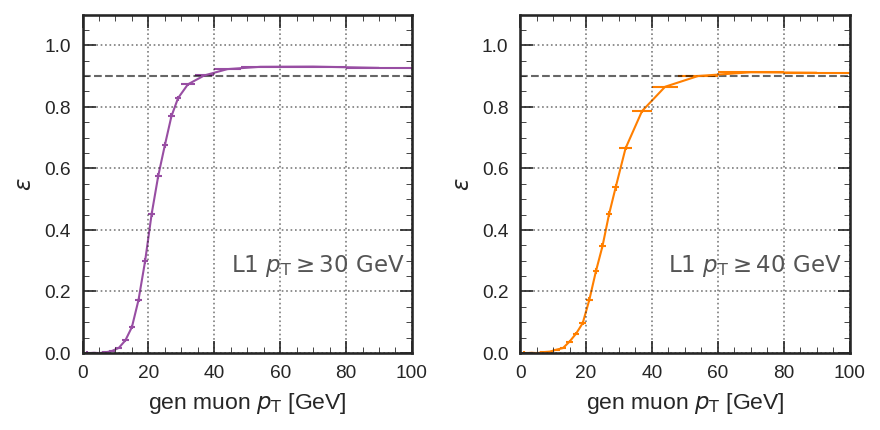

In [7]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

for i in range(2):
  if i == 0:
    # 30 GeV
    color = '#984ea3'
    denom_data = effie_data['eff_vs_genpt_all']
    num_data = effie_data['eff_vs_genpt_l1pt30']
    text = r'$\mathrm{L1}\ p_{\mathrm{T}} \geq 30~\mathrm{GeV}$'
  else:
    # 40 GeV
    color = '#ff7f00'
    denom_data = effie_data['eff_vs_genpt_all']
    num_data = effie_data['eff_vs_genpt_l1pt40']
    text = r'$\mathrm{L1}\ p_{\mathrm{T}} \geq 40~\mathrm{GeV}$'

  denom_hist, edges = np.histogram(denom_data, bins=eff_pt_bins_p2tdr)
  num_hist, edges = np.histogram(num_data, bins=eff_pt_bins_p2tdr)
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)

  ax = axs[i]
  xdata = (edges[1:] + edges[:-1]) / 2
  xerr = (edges[1:] - edges[:-1]) / 2
  yerr = emtf_nbtools.find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)
  ax.axhline(0.9, ls='dashed', lw=1, color='k', alpha=0.6)
  ax.set_xlim(edges[0], edges[-1])
  ax.set_ylim(0, 1.1)
  ax.set_xlabel(r'gen muon $p_{\mathrm{T}}$ [GeV]')
  ax.set_ylabel(r'$\varepsilon$')
  ax.text(0.45, 0.24, text, fontsize=11, color='#555', transform=axs[i].transAxes)

plt.show()

In [8]:
# Debug
a = effie_data['eff_vs_genpt_l1pt10']
b = effie_data['eff_vs_genpt_all']
logger.info('plateau eff @10 GeV: {:.3%}'.format(len(a[a >= 20]) / len(b[b >= 20])))
a = effie_data['eff_vs_genpt_l1pt20']
b = effie_data['eff_vs_genpt_all']
logger.info('plateau eff @20 GeV: {:.3%}'.format(len(a[a >= 40]) / len(b[b >= 40])))
a = effie_data['eff_vs_genpt_l1pt30']
b = effie_data['eff_vs_genpt_all']
logger.info('plateau eff @30 GeV: {:.3%}'.format(len(a[a >= 60]) / len(b[b >= 60])))
a = effie_data['eff_vs_genpt_l1pt40']
b = effie_data['eff_vs_genpt_all']
logger.info('plateau eff @40 GeV: {:.3%}'.format(len(a[a >= 80]) / len(b[b >= 80])))

[INFO    ] plateau eff @10 GeV: 95.581%
[INFO    ] plateau eff @20 GeV: 94.281%
[INFO    ] plateau eff @30 GeV: 92.863%
[INFO    ] plateau eff @40 GeV: 91.073%


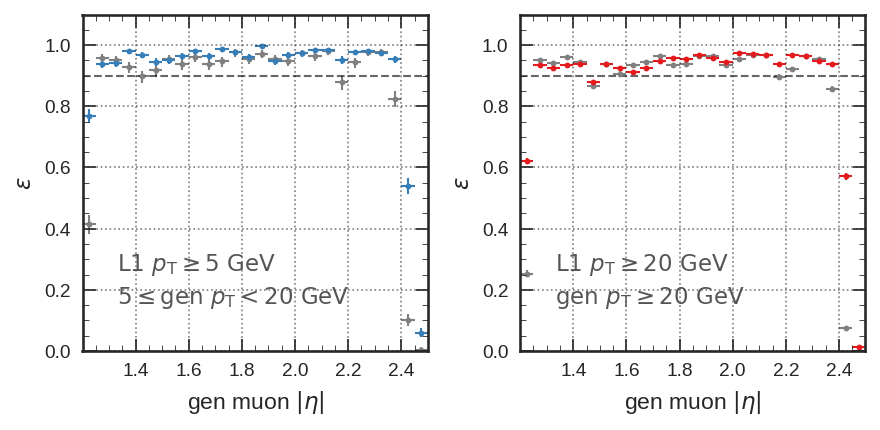

In [9]:
# Efficiency vs eta (comparison with p2tdr)
eff_eta_bins_p2tdr = np.array([1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75,
  1.8, 1.85, 1.9, 1.95, 2, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, ], dtype=np.float32)
num_hist_p2tdr_lowpt = np.array([118, 247, 247, 236, 255, 235, 257, 232, 253, 241, 266, 248, 286, 247,
  270, 272, 258, 265, 246, 231, 237, 269, 264, 207, 29, 1, ], dtype=np.int32)
denom_hist_p2tdr_lowpt = np.array([285, 258, 260, 254, 284, 256, 269, 247, 263, 257, 281, 254, 300, 254,
  283, 287, 265, 275, 251, 263, 251, 275, 270, 251, 288, 273, ], dtype=np.int32)
num_hist_p2tdr_highpt = np.array([361, 1427, 1350, 1364, 1349, 1231, 1364, 1312, 1319, 1347, 1283, 1216,
  1362, 1317, 1400, 1297, 1339, 1359, 1356, 1281, 1290, 1352, 1313, 1199, 106, 0, ], dtype=np.int32)
denom_hist_p2tdr_highpt = np.array([1431, 1500, 1432, 1419, 1428, 1423, 1454, 1447, 1412, 1425, 1331, 1302,
  1451, 1366, 1450, 1389, 1404, 1404, 1400, 1428, 1400, 1402, 1374, 1399, 1402, 1372, ], dtype=np.int32)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

for i in range(2):
  if i == 0:
    # 5 GeV
    color = '#377eb8'
    denom_data = effie_data['eff_vs_geneta_lowpt_all']
    num_data = effie_data['eff_vs_geneta_lowpt_l1pt5']
    color_ref = 'gray'
    denom_hist_ref = denom_hist_p2tdr_lowpt
    num_hist_ref = num_hist_p2tdr_lowpt
    text_1 = r'$\mathrm{L1}\ p_{\mathrm{T}} \geq 5~\mathrm{GeV}$'
    text_2 = r'$5 \leq \mathrm{gen}\ p_{\mathrm{T}} < 20~\mathrm{GeV}$'
  else:
    # 20 GeV
    color = '#e41a1c'
    denom_data = effie_data['eff_vs_geneta_highpt_all']
    num_data = effie_data['eff_vs_geneta_highpt_l1pt20']
    color_ref = 'gray'
    denom_hist_ref = denom_hist_p2tdr_highpt
    num_hist_ref = num_hist_p2tdr_highpt
    text_1 = r'$\mathrm{L1}\ p_{\mathrm{T}} \geq 20~\mathrm{GeV}$'
    text_2 = r'$\mathrm{gen}\ p_{\mathrm{T}} \geq 20~\mathrm{GeV}$'

  denom_hist, edges = np.histogram(denom_data, bins=eff_eta_bins_p2tdr)
  num_hist, edges = np.histogram(num_data, bins=eff_eta_bins_p2tdr)
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)
    eff_hist_ref = np.true_divide(num_hist_ref, denom_hist_ref)

  ax = axs[i]
  xdata = (edges[1:] + edges[:-1]) / 2
  xerr = (edges[1:] - edges[:-1]) / 2
  yerr = emtf_nbtools.find_efficiency_errors(denom_hist_ref, num_hist_ref)
  ydata = eff_hist_ref
  ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color_ref, marker='.', capsize=0, lw=1, ls='none')
  yerr = emtf_nbtools.find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker='.', capsize=0, lw=1, ls='none')
  ax.axhline(0.9, ls='dashed', lw=1, color='k', alpha=0.6)
  ax.set_xticks([1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
  ax.set_xlim(edges[0], edges[-1])
  ax.set_ylim(0, 1.1)
  ax.set_xlabel(r'gen muon $|\eta|$')
  ax.set_ylabel(r'$\varepsilon$')
  ax.text(0.10, 0.24, text_1, fontsize=11, color='#555', transform=axs[i].transAxes)
  ax.text(0.10, 0.14, text_2, fontsize=11, color='#555', transform=axs[i].transAxes)

plt.show()